#Tutorial: Deep Neural Networks
In this tutorial we will train a deep NN on the MNIST data set using Rectified Linear Unit (ReLU) activation in the hidden units and early stopping.  We will assume a 'sequential' model, densely connected layers and the RMSprop optimizer which are described in detail in the Tensorflow Keras documentation (see https://www.tensorflow.org/api_docs/python/tf/keras)

#Step 0 - Setup the learning environment

To begin, we import the Keras modules and functions that we will use, plus some plotting tools and then we set up the high-level learning parameters.  

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

train_size = 30000
batch_size = 128
num_classes = 10
epochs = 10

#print(tf.VERSION)
print(tf.keras.__version__)

print('Environment setup complete!')


2.8.0
Environment setup complete!


#Step 1 - Load and prepare the data
Note that we have 60k records for training (10k of which will be set aside for validation or 'tuning', the remaining 50k go toward the 'train' partition) and an additional 10k (*unseen*) test records.  The 784 dimension indicates flattening of the images that come as squares by default in the MNIST set. The class vectors are converted to 'categorical' labels for compatibility with Keras. The to_categorical function simply converts a class vector (integers) to binary class matrix.

In [8]:
math.sqrt(784)

28.0

In [9]:
# Load the train and test sets 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_tune = x_train[50000:60000]
x_train = x_train[0:train_size]
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_tune = x_tune.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_tune /= 255
x_test /= 255

# Print how many of each
print(x_train.shape[0], 'train samples')
print(x_tune.shape[0], 'tune samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices
y_tune = tf.keras.utils.to_categorical(y_train[50000:60000], num_classes)
y_train = tf.keras.utils.to_categorical(y_train[0:train_size], num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

30000 train samples
10000 tune samples
10000 test samples


#Step 2 - Architecture defintion
This model will consist of five layers (in, out and three hidden layers).  Note that we will assume a dropout rate of 0.2 meaning that there is a 20% chance that any given unit will become unavailable at each training epoch.  

RMSprop:	Optimizer keeps	a	moving	average	of	the	squared	gradient	for	each	weight.[http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf] 

A lot more about the sequential model API that we are using here can be found at: [https://keras.io/models/sequential/]

In [10]:
model = tf.keras.Sequential()

# Model consists of five layers as below
# Note: we do not explicitly define an input layer
model.add(layers.Dense(512, activation='relu', input_shape=(784,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(num_classes, activation='softmax'))

# Print a quick summary of the model to verify our work
model.summary()

# Compile using some 'typical' parameters for loss, optimizer and error metric
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


#Step 3 - Train the model 
The model API does all of the heavy lifting here, simply calling the fit and evalutate functions returns everything that we need to know about the model's results on train and test (NB: The tune partition being passed as validation data that will be used for early stopping). 

In [11]:
# Configure early stopping using validation accuracy from tune partition  
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                           patience=3, 
                                           verbose=1, 
                                           restore_best_weights=True)

# The history structure keeps tabs on what happened during the session
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_tune, y_tune),
                    callbacks=[stop_early],
                    shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

predictions = model.predict(x_test, verbose=0)

Epoch 1/10
235/235 [==============================] - 11s 45ms/step - loss: 1.2480 - accuracy: 0.8790 - val_loss: 0.3414 - val_accuracy: 0.9335
Epoch 2/10
235/235 [==============================] - 6s 26ms/step - loss: 0.3021 - accuracy: 0.9408 - val_loss: 0.2620 - val_accuracy: 0.9507
Epoch 3/10
235/235 [==============================] - 5s 23ms/step - loss: 0.2385 - accuracy: 0.9533 - val_loss: 0.3391 - val_accuracy: 0.9199
Epoch 4/10
235/235 [==============================] - 5s 23ms/step - loss: 0.2045 - accuracy: 0.9619 - val_loss: 0.2135 - val_accuracy: 0.9573
Epoch 5/10
235/235 [==============================] - 6s 24ms/step - loss: 0.1817 - accuracy: 0.9664 - val_loss: 0.2005 - val_accuracy: 0.9606
Epoch 6/10
235/235 [==============================] - 5s 22ms/step - loss: 0.1657 - accuracy: 0.9705 - val_loss: 0.1920 - val_accuracy: 0.9642
Epoch 7/10
235/235 [==============================] - 5s 23ms/step - loss: 0.1520 - accuracy: 0.9729 - val_loss: 0.1922 - val_accuracy: 0.961

# Step 4 - Plot the results
Simply plotting the actual test image along with the what the model predicted (pred) as a value represented in the image.  We are plotting 5 results but setting r to something else will print more or less results.   

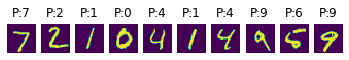

In [12]:
r = 10

for i in range(r):
    subplt = plt.subplot(int(i / r) + 1, r, i + 1)
    # no sense in showing labels if they don't match the letter
    hot_index = np.argmax(predictions[i])
    subplt.set_title('P:{0}'.format(hot_index))
    subplt.axis('off')
    letter = x_test[i]
    subplt.matshow(np.reshape(letter, [28, 28]))
    plt.draw()
    
plt.show()